In [2]:
import numpy as np
import matplotlib.pyplot as plt
from compton import ComptonScattering


def plot_turb(ax, x, y, ndens, Vx, Vy, Vz, width=2):
    ax.pcolormesh(x, y, ndens, cmap="inferno")
    ax.streamplot(
        x,
        y,
        Vx,
        Vy,
        color="w",
        density=2,
        linewidth=(Vx**2 + Vy**2 + Vz**2) / np.max(Vx**2 + Vy**2 + Vz**2) * width,
        arrowsize=1,
        arrowstyle="->",
    )

    ax.set(
        aspect=1,
        xlim=(x.min(), x.max()),
        ylim=(y.min(), y.max()),
    )

In [3]:
data = np.load("turb2d-256.npz")

In [4]:
xmin, xmax, ymin, ymax = -2500, 2500, -2500, 2500

x, y = data["x"], data["y"]
ndens = data["ndens"]

Vx, Vy, Vz = data["Vx"], data["Vy"], data["Vz"]

#### Tasks:

- [x] a photon propagates, and randomly scatters in the direction of the bulk velocity of the cell
    - [x] vary probability at each step and see what happens
- [ ] scattering probability depends on the density of the cell
    - [ ] define mean-free path for given density and vary it
    - [ ] define an "optical depth" for the whole box and vary it
- [ ] the photon gains/loses energy depending on the bulk velocity of the cell
    - [ ] transform to the rest frame of the cell (transform velocity & photon momentum)
    - [ ] scatter the photon in the rest frame (Compton formula)
    - [ ] transform back to the lab frame

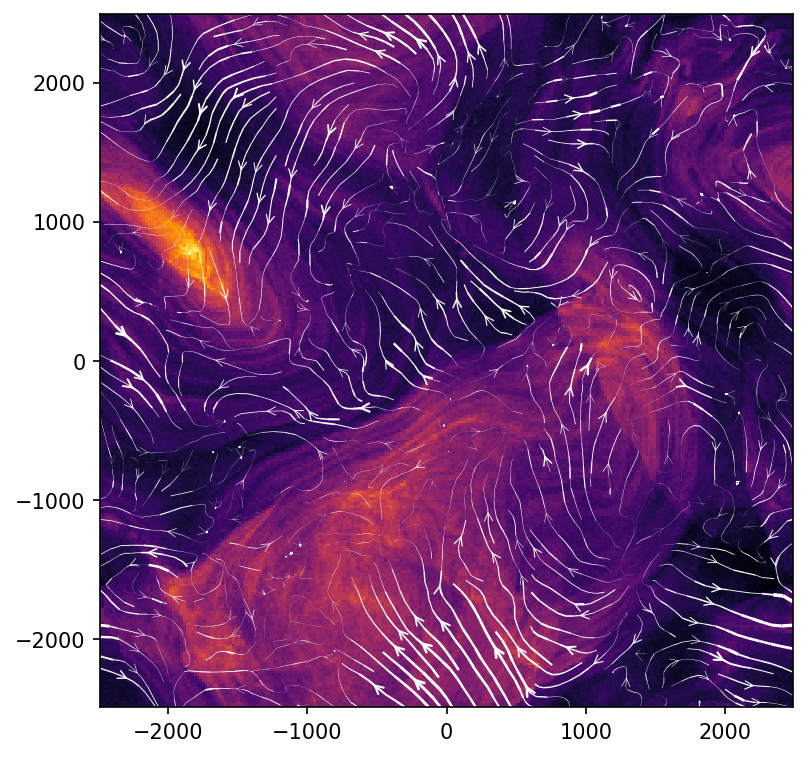

In [5]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

plot_turb(ax, x, y, ndens, Vx, Vy, Vz)

Photon momentum ($c=1$, speed of light is equal to $1$):

$\bm{P} = (E/c) \hat{\bm{k}}$,

where $E$ is photon's energy, and $\hat{\bm{k}}$ is a unit vector (direction of motion).

$|\bm{P}| = E/c$ -- length of the vector $\bm{P}$.

$\bm{P} / |\bm{P}| = \hat{\bm{k}}$

$\bm{x}_{\rm new} = \bm{x}_{\rm old} + \bm{k} c \Delta t$

In [11]:
photon_mom_ = np.array([0.2, 1, 2, 0])

photon_mom = np.array(
    [photon_mom_[0], *(photon_mom_[0] * photon_mom_[1:] / np.linalg.norm(photon_mom_[1:]))]
)
photon_mom

array([0.2       , 0.08944272, 0.17888544, 0.        ])

In [ ]:
sy, sx = ndens.shape

photon_pos = [np.array([0, 0, 0])]
photon_mom_ = np.array([0.2, 1, 2, 0])

photon_mom = [
    np.array(
        [
            photon_mom_[0],
            *(photon_mom_[0] * photon_mom_[1:] / np.linalg.norm(photon_mom_[1:])),
        ]
    )
]

rng = np.random.default_rng()


def advance(pos, mom, dt):
    newpos = pos.copy()
    newmom = mom.copy()

    # draw a random number
    rand = rng.random()
    if rand < 0.002:
        xph, yph, zph = newpos
        ixph = int((xph - xmin) * sx / (xmax - xmin))
        iyph = int((yph - ymin) * sy / (ymax - ymin))
        vx = Vx[iyph, ixph]
        vy = Vy[iyph, ixph]
        vz = Vz[iyph, ixph]
        Gamma = 1 / np.sqrt(1 - vx**2 - vy**2 - vz**2)
        newmom = ComptonScattering(newmom, np.array([Gamma, vx, vy, vz]))
        # newmom = np.array([vx, vy, vz])

    # advance photon position
    newpos = pos + (newmom[1:] / newmom[0]) * dt

    # boundary conditions:
    if newpos[0] < xmin:
        newpos[0] += xmax - xmin
    if newpos[0] > xmax:
        newpos[0] -= xmax - xmin
    if newpos[1] < ymin:
        newpos[1] += ymax - ymin
    if newpos[1] > ymax:
        newpos[1] -= ymax - ymin

    return newpos, newmom


for _ in range(300):
    photon_newpos, photon_newmom = advance(photon_pos[-1], photon_mom[-1], 10)
    photon_pos = np.vstack([photon_pos, photon_newpos])
    photon_mom = np.vstack([photon_mom, photon_newmom])

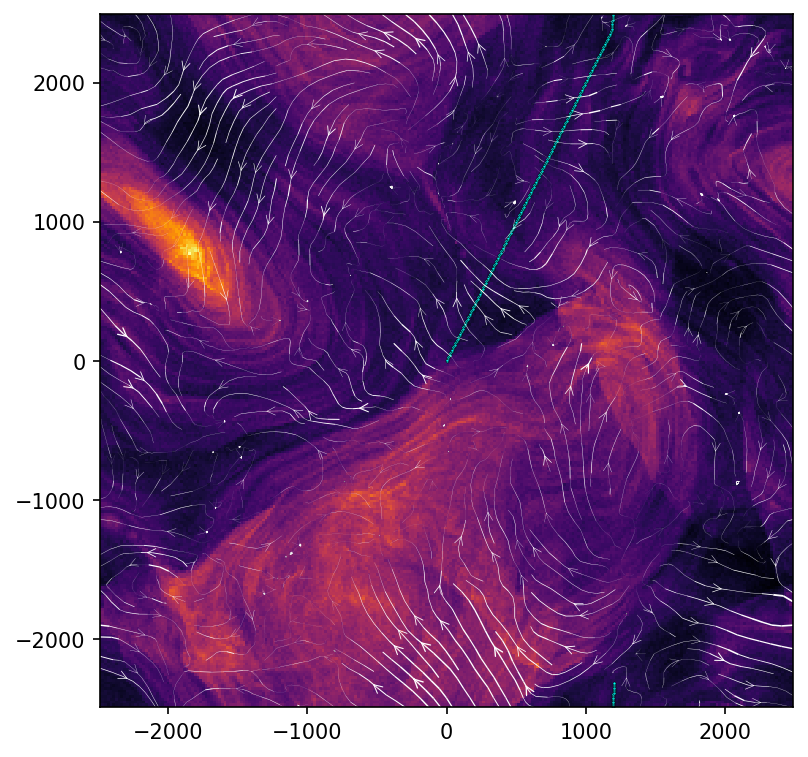

In [51]:
interval = 1

fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

plot_turb(ax, x, y, ndens, Vx, Vy, Vz, width=1)

ax.scatter(photon_pos[:, 0][::interval], photon_pos[:, 1][::interval], color="cyan", s=2, edgecolor="k", lw=0.25)

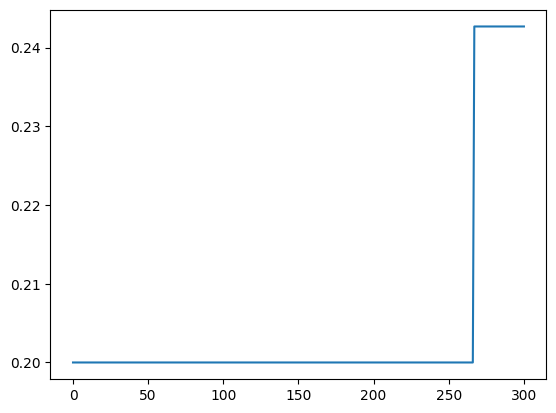

In [50]:
plt.plot(photon_mom[:, 0])

Question:

What's the maximum timestep `dt` we can pick to still physically make sense???

Task:
1. Wrap the algorithm into a function which accepts a list of photon momenta, and runs the simulation for each, returning the final momentum of each of the input photons.
2. Run the simulation for a series of random photons.

Task for Hayk:
1. Figure out the probability scaling with `dt`.
2. ... scaling with density.